# Hands-on Day 3

## You'll learn

### ML methods

- Deep NN with keras

# Initial setup 

- read in parquet file
- create x,y vectors from panda dataframe

In [1]:
%reload_ext custom_functions
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [4]:
# inputFile = "file:///home/jovyan/Higgs100k.parquet"
inputFile = "file:///home/jovyan/Higgs1M.parquet"
# inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

CPU times: user 1.2 s, sys: 682 ms, total: 1.89 s
Wall time: 258 ms


In [5]:
# The first column is the target variable
y = df.iloc[:, 0]  # df with label
x = df.iloc[:, 1:]  # df with all other variables

len(x)

999999

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [7]:
# sanity check

print(len(x_train) + len(x_test))
print(len(y_train) + len(y_test))

999999
999999


# ML Models: Sequential

We will use Keras with Tensorflow as backend (supports multi-core and GPUs)

In [8]:
# ignore warnings from Tensorflow
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=DeprecationWarning)
import tensorflow as tf

# if type(tf.contrib) != type(tf): tf.contrib._warning = None
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# import Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(1337)  # for reproducibility

## Exercise 1

- documentation: https://keras.io/getting-started/sequential-model-guide/
- Build (compile) a Keras Sequential model (call it *model*)
  - 1 hidden layer  with 100 neurons, activation ReLU (put in the correct input_shape!)
  - 1 ouput layer with activation sigmoid
  - use Adam optimiser
  - use binary_crossentropy loss
  - use accuracy metrics 

In [9]:
# create the model
model = Sequential()
model.add(Input(shape=(28,)))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2900      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [10]:
# compile the model
optim = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optim, loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
# simple early stopping
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

In [12]:
# set batch size according to size of the input sample!!!
# start training with reasonable numer of epoch

%time history = model.fit(x, y, batch_size=128, epochs=10, validation_data=(x_test, y_test), callbacks=[es]) #, verbose=0)

Epoch 1/10
7813/7813 [==============================] - 18s 2ms/step - loss: 0.6038 - accuracy: 0.6708 - val_loss: 0.5839 - val_accuracy: 0.6911
Epoch 2/10
7813/7813 [==============================] - 17s 2ms/step - loss: 0.5809 - accuracy: 0.6937 - val_loss: 0.5753 - val_accuracy: 0.6994
Epoch 3/10
7813/7813 [==============================] - 17s 2ms/step - loss: 0.5748 - accuracy: 0.6987 - val_loss: 0.5667 - val_accuracy: 0.7058
Epoch 4/10
7813/7813 [==============================] - 17s 2ms/step - loss: 0.5701 - accuracy: 0.7035 - val_loss: 0.5728 - val_accuracy: 0.7053
Epoch 5/10
7813/7813 [==============================] - 16s 2ms/step - loss: 0.5676 - accuracy: 0.7055 - val_loss: 0.5629 - val_accuracy: 0.7080
Epoch 6/10
7813/7813 [==============================] - 17s 2ms/step - loss: 0.5661 - accuracy: 0.7062 - val_loss: 0.5638 - val_accuracy: 0.7108
Epoch 7/10
7813/7813 [==============================] - 17s 2ms/step - loss: 0.5653 - accuracy: 0.7066 - val_loss: 0.5604 - val_ac

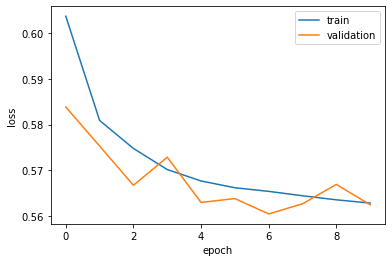

In [13]:
plotVsEpoch(history, "loss")

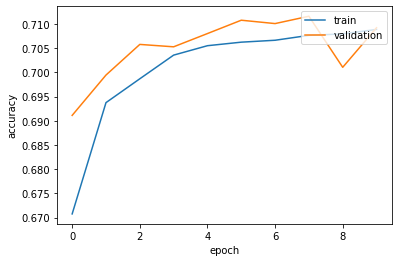

In [14]:
plotVsEpoch(history, "accuracy")

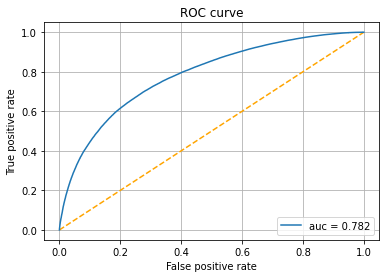

In [15]:
# apply model to get predictions on test set
y_pred = model.predict(x_test)

# draw ROC
drawROC2(y_test, y_pred)

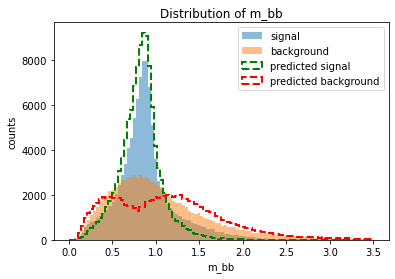

In [16]:
# plot signal vs background with prediction
variable = "m_bb"

# Get the predicted probabilities for the positive class
y_pred_prob = model.predict(x_test).ravel()  # Use .ravel() to flatten to a 1D array

plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred_prob)

# Hyperparameters optimisation

- you can use [keras_tuner](https://keras.io/keras_tuner/) for hyperparameter optimisation

In [17]:
import keras_tuner as kt

In [18]:
# you may need to install it with
!pip install --user keras-tuner

## Exercise 2

- play with the model parameters and see if you can improve the performances
- try to increase the number of epochs for training, is the model improving?
- how is training time affected by the number of parameters?
- how is signal versus background separation affected (check different variables)

In [19]:
# read in input parquet file
# inputFile = "file:///home/jovyan/Higgs100k.parquet"
inputFile = "file:///home/jovyan/Higgs1M.parquet"

%time df = pd.read_parquet(inputFile)

# create train/test set
y = df.iloc[:, 0]  # df with label
x = df.iloc[:, 1:]  # df with all other variables

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)
len(y)

CPU times: user 1.03 s, sys: 913 ms, total: 1.95 s
Wall time: 183 ms


999999

In [20]:
import keras_tuner as kt


# Define the model-building function
def build_model(hp):
    model = Sequential()

    # Tune the number of units in the hidden layers
    model.add(
        Dense(
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            activation="relu",
            input_dim=x_train.shape[1],
        )
    )

    # Add a dropout layer - not a good idea because it is not used for inference
    # unwanted regularization effect that makes better accuracy on test than on train
    # model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))  # Binary classification

    # Tune the learning rate for the optimizer
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Float(
                "learning_rate", min_value=1e-5, max_value=1e-2, sampling="LOG"
            )
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model


In [22]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",  # Optimization target
    max_trials=5,  # Number of models to try
    executions_per_trial=3,  # Number of executions for each trial
    directory="keras",  # Directory to store the results
    project_name="bigDataML",
)


In [23]:
# Run the hyperparameter search
%time tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Trial 5 Complete [00h 28m 41s]
val_accuracy: 0.6917349894841512

Best val_accuracy So Far: 0.7234249909718832
Total elapsed time: 02h 18m 26s
CPU times: user 6h 52min 47s, sys: 2h 41min 13s, total: 9h 34min
Wall time: 2h 18min 25s


In [24]:
# Get the best model and parameters
best_model = tuner.get_best_models(num_models=1)[0]
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Units: {best_params['units']}")
# print(f"Dropout: {best_params['dropout']}")
print(f"Learning Rate: {best_params['learning_rate']}")

# Evaluate the best model
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Best Hyperparameters:
Units: 128
Learning Rate: 0.0006556212188245471
6250/6250 [==============================] - 5s 836us/step - loss: 0.5409 - accuracy: 0.7260
Test Loss: 0.5409
Test Accuracy: 0.7260


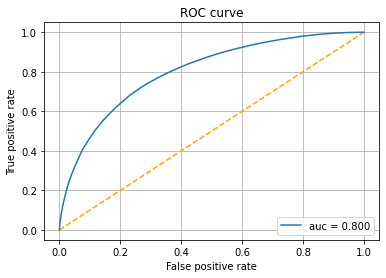

In [25]:
# apply model to get predictions on test set
y_pred = best_model.predict(x_test)

# draw ROC
drawROC2(y_test, y_pred)

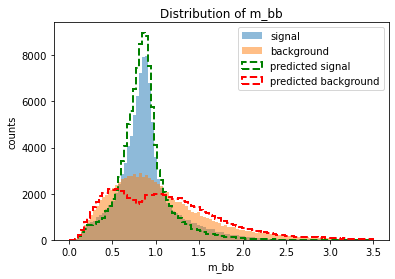

In [26]:
# plot signal vs background with prediction
variable = "m_bb"

# Get the predicted probabilities for the positive class
y_pred_prob = best_model.predict(
    x_test
).ravel()  # Use .ravel() to flatten to a 1D array

plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred_prob)

In [27]:
# Print a summary of the model architecture
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3712      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
_________________________________________________________________


## Train best model on 10M events

In [28]:
# read in input parquet file
input_file = "Higgs10M.parquet"
%time df = pd.read_parquet(input_file)

# create train/test set
y = df.iloc[:, 0]  # df with label
x = df.iloc[:, 1:]  # df with all other variables

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)
len(y)

CPU times: user 5.37 s, sys: 4.39 s, total: 9.76 s
Wall time: 7.47 s


10000000

In [29]:
# Rebuild the model using these best hyperparameters
new_best_model = build_model(best_params)

# Compile the model with the same loss and metrics as used previously
new_best_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  # or whichever loss you used
    metrics=["accuracy"],
)

In [30]:
%%time
new_history = new_best_model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[es],
)  # , verbose=0)

Epoch 1/30
15625/15625 [==============================] - 55s 3ms/step - loss: 0.5792 - accuracy: 0.6939 - val_loss: 0.5526 - val_accuracy: 0.7172
Epoch 2/30
15625/15625 [==============================] - 55s 4ms/step - loss: 0.5435 - accuracy: 0.7228 - val_loss: 0.5351 - val_accuracy: 0.7289
Epoch 3/30
15625/15625 [==============================] - 54s 3ms/step - loss: 0.5325 - accuracy: 0.7302 - val_loss: 0.5307 - val_accuracy: 0.7313
Epoch 4/30
15625/15625 [==============================] - 54s 3ms/step - loss: 0.5277 - accuracy: 0.7334 - val_loss: 0.5255 - val_accuracy: 0.7340
Epoch 5/30
15625/15625 [==============================] - 55s 4ms/step - loss: 0.5247 - accuracy: 0.7352 - val_loss: 0.5237 - val_accuracy: 0.7361
Epoch 6/30
15625/15625 [==============================] - 54s 3ms/step - loss: 0.5225 - accuracy: 0.7367 - val_loss: 0.5226 - val_accuracy: 0.7370
Epoch 7/30
15625/15625 [==============================] - 54s 3ms/step - loss: 0.5210 - accuracy: 0.7375 - val_loss: 0

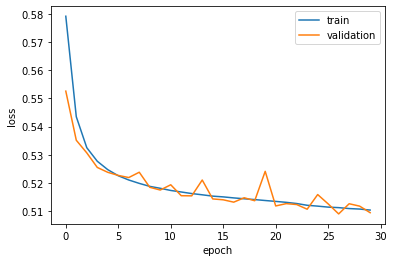

In [31]:
plotVsEpoch(new_history, "loss")

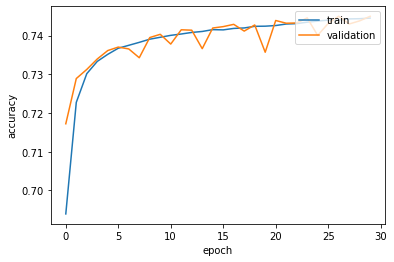

In [32]:
plotVsEpoch(new_history, "accuracy")

In [33]:
print(new_history.params)
print(new_history.history.keys())

{'verbose': 1, 'epochs': 30, 'steps': 15625}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [34]:
# Evaluate the model on the test set
test_loss, test_accuracy = new_best_model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

62500/62500 [==============================] - 70s 1ms/step - loss: 0.5094 - accuracy: 0.7450
Test Loss: 0.5094
Test Accuracy: 0.7450


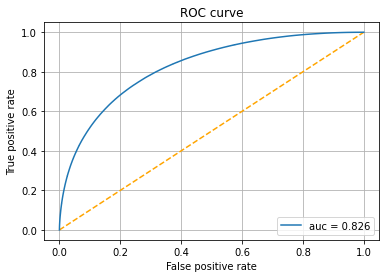

In [35]:
# apply model to get predictions on test set
y_pred = new_best_model.predict(x_test)

# draw ROC
drawROC2(y_test, y_pred)

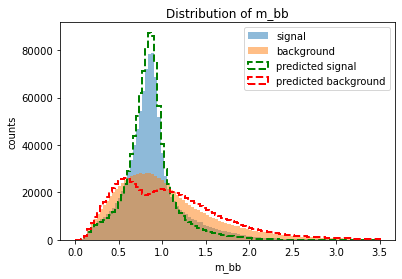

In [36]:
# plot signal vs background with prediction
variable = "m_bb"

# Get the predicted probabilities for the positive class
y_pred_prob = new_best_model.predict(
    x_test
).ravel()  # Use .ravel() to flatten to a 1D array

plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred_prob)